In [23]:
import numpy as np

# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [24]:
label_range=5 #minutes the are togheter in the same class
number_of_classifiers=60//label_range

label=y.copy()
label[:,1]=label[:,1]//label_range

print(label[17999])
print(y[17999])
print(number_of_classifiers)

[11 11]
[11 59]
12


In [25]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, label, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(y_test.shape)
print(y_val.shape)
print(y_train.shape)
print(y_train[0].shape)

(1800, 2)
(1800, 2)
(14400, 2)
(2,)


In [26]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


In [27]:
model_body = keras.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
])

hours_head=keras.Sequential([
    #layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    #layers.Dropout(0.4),
    layers.Dense(12, activation="softmax")],name="hours")

hours_minutes=keras.Sequential([
    #layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    #layers.Dropout(0.4),
    layers.Dense(number_of_classifiers, activation="softmax")],name="minutes")


input=keras.Input(shape=X[0].shape)
x=model_body(input)
out_hours=hours_head(x)
out_minutes=hours_minutes(x)

model=keras.Model(inputs=input, outputs=[out_hours,out_minutes])



In [28]:
model.compile(
    optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
    loss={"hours":"sparse_categorical_crossentropy", "minutes":"sparse_categorical_crossentropy"},
    #loss_weights={"hours":number_of_classifiers,"minutes":1},
    metrics={
        "hours": ["accuracy"],
        "minutes": ["accuracy"]}
)

In [29]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True
)

In [30]:
history_base = model.fit(
    X_train, [y_train[:,0],y_train[:,1]],
    epochs=100,
    batch_size=64,
    validation_data=(X_val, [y_val[:,0],y_val[:,1]]),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/100


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - hours_accuracy: 0.1254 - hours_loss: 2.4044 - loss: 4.7709 - minutes_accuracy: 0.1416 - minutes_loss: 2.3496 - val_hours_accuracy: 0.0889 - val_hours_loss: 3.9130 - val_loss: 7.7565 - val_minutes_accuracy: 0.0806 - val_minutes_loss: 3.8322 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - hours_accuracy: 0.1902 - hours_loss: 2.1719 - loss: 4.2001 - minutes_accuracy: 0.2391 - minutes_loss: 2.0109 - val_hours_accuracy: 0.0694 - val_hours_loss: 5.8354 - val_loss: 12.7483 - val_minutes_accuracy: 0.0661 - val_minutes_loss: 6.9036 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - hours_accuracy: 0.2638 - hours_loss: 1.9151 - loss: 3.6253 - minutes_accuracy: 0.3396 - minutes_loss: 1.6918 - val_hours_accuracy: 0.1439 - val_hours_loss: 2.4722 - val_loss: 5.4482 - val_minutes_accuracy: 0.0917 - val_minutes_loss: 2.9432 - learning_rate: 5.0000e-04
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━

In [31]:
# Carichiamo il modello salvato con i pesi migliori
best = keras.models.load_model("best_model.keras")

# Prepara le etichette
y_train_hours = keras.utils.to_categorical(y_train[:, 0], num_classes=12)
y_train_minutes = keras.utils.to_categorical(y_train[:, 1], num_classes=number_of_classifiers)

y_test_hours = keras.utils.to_categorical(y_test[:, 0], num_classes=12)
y_test_minutes = keras.utils.to_categorical(y_test[:, 1], num_classes=number_of_classifiers)

results_train = best.evaluate(
    X_train, {"hours": y_train[:, 0], "minutes": y_train[:, 1]}, verbose=0
)

results_test = best.evaluate(
    X_test, {"hours": y_test[:, 0], "minutes": y_test[:, 1]}, verbose=0
)


print("\n📊 Risultati sul TRAIN set:")
for name, value in zip(best.metrics_names, results_train):
    print(f"{name}: {value:.4f}")


print("\n📊 Risultati sul TEST set:")
for name, value in zip(best.metrics_names, results_test):
    print(f"{name}: {value:.4f}")



📊 Risultati sul TRAIN set:
loss: 0.0576
compile_metrics: 0.0054
hours_loss: 0.0065
minutes_loss: 1.0000

📊 Risultati sul TEST set:
loss: 0.2293
compile_metrics: 0.0486
hours_loss: 0.1397
minutes_loss: 0.9872


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
 Accuracy ore: 0.9872
 Accuracy minuti: 0.9522
 Accuracy media complessiva: 0.9697
Confusion matrix - ORE

Confusion matrix - MINUTI


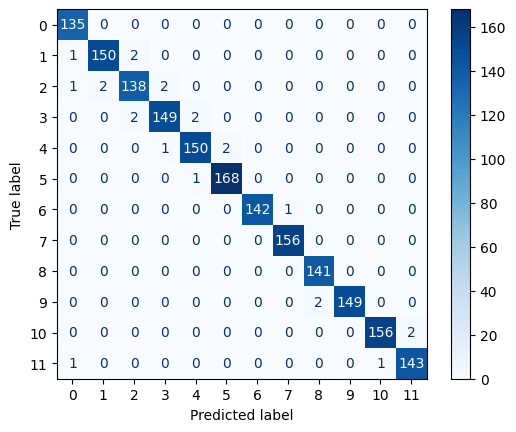

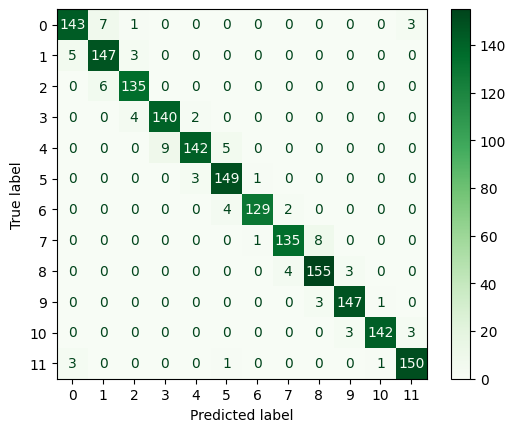

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Predizioni del modello
y_pred_hours, y_pred_minutes = best.predict(X_test)

# Conversione in classi (argmax su ogni testa)
y_pred_hours_classes = np.argmax(y_pred_hours, axis=1)
y_pred_minutes_classes = np.argmax(y_pred_minutes, axis=1)

# Matrici di confusione
cm_hours = confusion_matrix(y_test[:, 0], y_pred_hours_classes)
cm_minutes = confusion_matrix(y_test[:, 1], y_pred_minutes_classes)

# Accuratezze
acc_hours = accuracy_score(y_test[:, 0], y_pred_hours_classes)
acc_minutes = accuracy_score(y_test[:, 1], y_pred_minutes_classes)
acc_mean = (acc_hours + acc_minutes) / 2

print(f" Accuracy ore: {acc_hours:.4f}")
print(f" Accuracy minuti: {acc_minutes:.4f}")
print(f" Accuracy media complessiva: {acc_mean:.4f}")

# Visualizzazione
print("Confusion matrix - ORE")
ConfusionMatrixDisplay(cm_hours).plot(cmap="Blues")

print("\nConfusion matrix - MINUTI")
ConfusionMatrixDisplay(cm_minutes).plot(cmap="Greens")



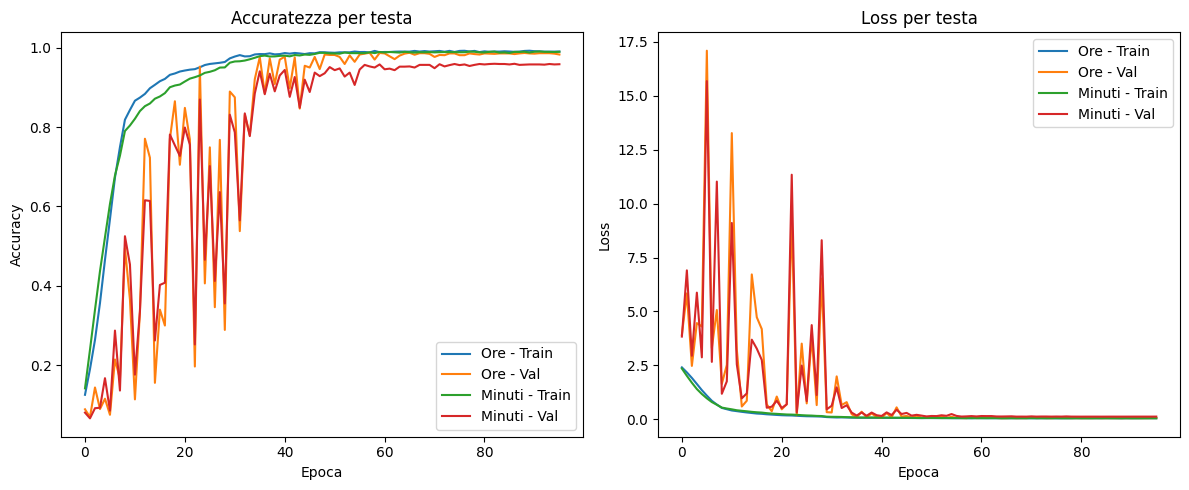

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(history_base.history["hours_accuracy"], label="Ore - Train")
plt.plot(history_base.history["val_hours_accuracy"], label="Ore - Val")
plt.plot(history_base.history["minutes_accuracy"], label="Minuti - Train")
plt.plot(history_base.history["val_minutes_accuracy"], label="Minuti - Val")
plt.title("Accuratezza per testa")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(history_base.history["hours_loss"], label="Ore - Train")
plt.plot(history_base.history["val_hours_loss"], label="Ore - Val")
plt.plot(history_base.history["minutes_loss"], label="Minuti - Train")
plt.plot(history_base.history["val_minutes_loss"], label="Minuti - Val")
plt.title("Loss per testa")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
